In [2]:
import tensorflow as tf
from keras import backend as K
from keras.models import load_model

import os
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.externals import joblib

sys.path.append(os.path.join(os.path.dirname('__file__'), "./src/"))
from utilFunctions import smooth_obs
from audio_preprocessing import getMFCCBands2DMadmom
from madmom.features.onsets import OnsetPeakPickingProcessor
from training_scripts.data_preparation import featureReshape

In [3]:
def boundary_decoding(obs_i,
                      threshold,
                      hopsize_t,
                      OnsetPeakPickingProcessor):

    """decode boundary"""
    arg_pp = {'threshold': threshold,
              'smooth': 0,
              'fps': 1. / hopsize_t,
              'pre_max': hopsize_t,
              'post_max': hopsize_t}

    peak_picking = OnsetPeakPickingProcessor(**arg_pp)
    i_boundary = peak_picking.process(obs_i)
    i_boundary = np.append(i_boundary, (len(obs_i) - 1) * hopsize_t)
    i_boundary /= hopsize_t
    return i_boundary
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [18]:
import numpy as np

with open("training_data/labels.npz", 'rb') as f:
    data = np.load(f)['labels']

In [4]:
model = load_model(os.path.join("models/" + 'trained_model.h5'), custom_objects={ 'auc': auc})

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 80, 15)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 78, 9)         220       
_________________________________________________________________
batch_normalization_5 (Batch (None, 10, 78, 9)         40        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 26, 9)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 24, 7)         1820      
_________________________________________________________________
batch_normalization_6 (Batch (None, 20, 24, 7)         80        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 8, 7)          0         
__________

In [5]:
scaler = []

if model.layers[0].input_shape[1] != 1:
    multi = True
else:
    multi = False

if multi:
    with open("training_data/scaler_low.pkl", "rb") as file:
        scaler.append(joblib.load(file))
    with open("training_data/scaler_mid.pkl", "rb") as file:
        scaler.append(joblib.load(file))
    with open("training_data/scaler_high.pkl", "rb") as file:
        scaler.append(joblib.load(file))
else:
    with open("training_data/scaler.pkl", "rb") as file:
        scaler.append(joblib.load(file))

In [6]:
wav = 'wavs/0x1311.wav'

if multi:
    log_mel = getMFCCBands2DMadmom(wav, 44100, 0.01, channel=3)

    log_mel[:, :, 0] = scaler[0].transform(log_mel[:, :, 0])
    log_mel[:, :, 1] = scaler[1].transform(log_mel[:, :, 1])
    log_mel[:, :, 2] = scaler[2].transform(log_mel[:, :, 2])
else:
    log_mel = getMFCCBands2DMadmom(wav, 44100, 0.01, channel=1)
    log_mel = scaler[0].transform(log_mel)

In [7]:
log_mel_re = featureReshape(log_mel, multi, 7)
if not multi:
    log_mel_re = np.expand_dims(log_mel_re, axis=1)
pdf = model.predict(log_mel_re)
pdf = np.squeeze(pdf)
pdf = smooth_obs(pdf)

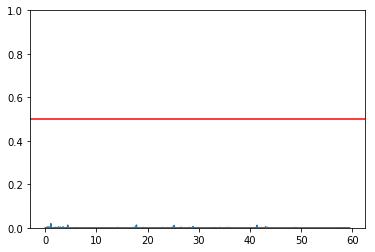

In [8]:
snip = pdf[50: 60*100]
x = np.arange(0, len(snip)) * 0.01
plt.plot(x, snip)
plt.axhline(y=0.5, color='r', linestyle='-')
plt.ylim(0, 1)
plt.show()

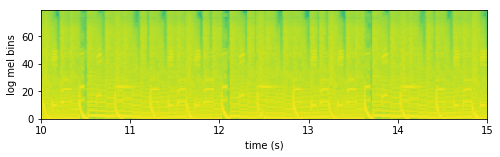

In [66]:
plt.figure(figsize=(8,2))
y = np.arange(0, 80)
x = np.arange(0, log_mel.shape[0]) * 0.01
plt.pcolormesh(x, y, np.transpose(log_mel_te[:, :, 7, 0]))
plt.ylabel('log mel bins')
plt.xlabel('time (s)')
plt.xlim(10, 15)
plt.show()

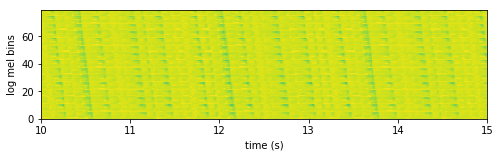

In [50]:
plt.figure(figsize=(8,2))
y = np.arange(0, 80)
x = np.arange(0, log_mel.shape[0]) * 0.01
plt.pcolormesh(x, y, np.transpose(log_mel_re[:, :, 7, 0]))
plt.ylabel('log mel bins')
plt.xlabel('time (s)')
plt.xlim(10, 15)
plt.show()

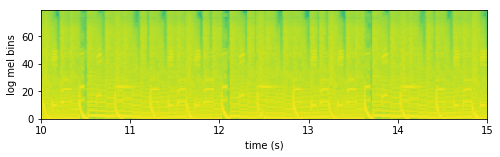

In [38]:
plt.figure(figsize=(8,2))
y = np.arange(0, 80)
x = np.arange(0, log_mel.shape[0]) * 0.01
plt.pcolormesh(x, y, np.transpose(log_mel[:, 80 * 7:80 * 8,0]))
plt.ylabel('log mel bins')
plt.xlabel('time (s)')
plt.xlim(10, 15)
plt.show()

In [9]:
b_baseline = boundary_decoding(obs_i=pdf,
                              threshold=0.5,
                              hopsize_t=0.01,
                              OnsetPeakPickingProcessor=OnsetPeakPickingProcessor)
b_baseline.shape

(1,)

In [11]:
lines = []
with open("timings/0x1311.txt", "r") as file:
    lines = file.readlines()
    lines = np.asarray([x.replace("\n", "").split(" ")[1] for x in lines[3:]]).astype("float")
lines.shape

(739,)

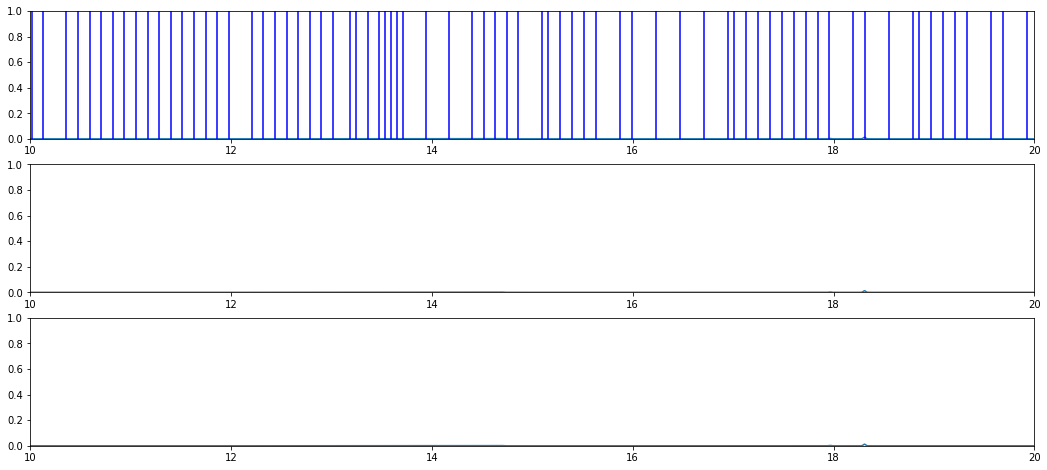

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True)
fig.set_size_inches(18, 8)
start = 10
end = 20
snip = pdf[start * 100: end*100]
x = np.arange(start*100, end*100) * 0.01

ax1 = plt.subplot(311)
ax1.plot(x, snip)
#plt.axhline(y=0.5, color='r', linestyle='-')
for mark in lines:
    if mark < start:
        continue
    elif mark > end:
        break
    ax1.axvline(x=mark, color= 'b')
plt.xlim(start, end)
plt.ylim(0, 1)

ax2 = plt.subplot(312)
ax2.plot(x, snip)
#plt.axhline(y=0.5, color='r', linestyle='-')
for mark in b_baseline*0.01:
    if mark < start:
        continue
    elif mark > end:
        break
    ax2.axvline(x=mark, color= 'y')
plt.xlim(start, end)
plt.ylim(0, 1)

ax3 = plt.subplot(313)
ax3.plot(x, snip)
#plt.axhline(y=0.5, color='r', linestyle='-')
for i, mark in enumerate(pdf):
    if i/100 < start:
        continue
    elif i/100 > end:
        break
    if mark > 0.5:
        ax3.axvline(x=i/100, color= 'y')
plt.xlim(start, end)
plt.ylim(0, 1)

plt.show()